In [136]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

import matplotlib.pyplot as plt
import numpy as np

import random
import cv2

# Load images

In [137]:
train_path = './seg_train/'
test_path = './seg_test/'

In [138]:
def randomBlackPatch(img):
    patchSize = random.randint(0,38)
    x, y = img.shape[:2]  # Get image dimensions
    x_start = np.random.randint(0, x - patchSize)
    y_start = np.random.randint(0, y - patchSize)
    img[x_start:x_start + patchSize, y_start:y_start + patchSize] = 0
    return img

In [139]:
def rotateImg(img):
    angle = random.randint(0, 45)
    
    (h, w) = img.shape[:2]
    center = (w // 2, h // 2)
    
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated_img = cv2.warpAffine(img, M, (w, h))
    
    return rotated_img


In [140]:
def shiftImg(img):
  configuration = random.choice(["sideward","upward","na"])
  magnitude = random.randint(0,10)
  height, width = img.shape[:2]

  if(configuration == "sideward"):
    M = np.float32([[1,0,magnitude],[0,1,0]])
    dst = cv2.warpAffine(img,M,(width,height))
    return dst
  elif(configuration=="upward"):
    M = np.float32([[1,0,0],[0,1,-magnitude]])
    dst = cv2.warpAffine(img,M,(width,height))
    return dst
  else:
      return img


In [141]:
def flipImg(img):
    flip_code = random.randint(-1,2)
    if(flip_code == 2):
        return img
    else:
    # flip_code: 0 for vertical, 1 for horizontal, -1 for both
        flipped_img = cv2.flip(img, flip_code)
        return flipped_img

In [142]:
def reshape(img):
    resized_img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_CUBIC)
    return resized_img
    

In [143]:
def combined_preprocessing_function(image):
    image = reshape(image)
    image = randomBlackPatch(image)
    image = rotateImg(image)
    image = shiftImg(image)
    image = flipImg(image)
    return image

In [144]:
# For training: Include augmentation and preprocessing

# Preprocessing tools. (flips ,rotation, and patch.)
train_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = combined_preprocessing_function,
    validation_split=0.2 
)

# Load data, reisze of 224, 224
train_data_gen = train_image_generator.flow_from_directory(
    directory=train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    seed=42
)

# For validation: No augmentation, only resizing and normalization
val_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    validation_split=0.2  # Same split as training data
)

val_data_gen = val_image_generator.flow_from_directory(
    directory=train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    seed=42
)


Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.


In [145]:
print("Class Indices:", train_data_gen.class_indices)
print("Classes:", list(train_data_gen.class_indices.keys()))

Class Indices: {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [146]:
class_indices = train_data_gen.class_indices
reversed_class_indices = {v: k for k, v in class_indices.items()}
print(reversed_class_indices)

{0: 'buildings', 1: 'forest', 2: 'glacier', 3: 'mountain', 4: 'sea', 5: 'street'}


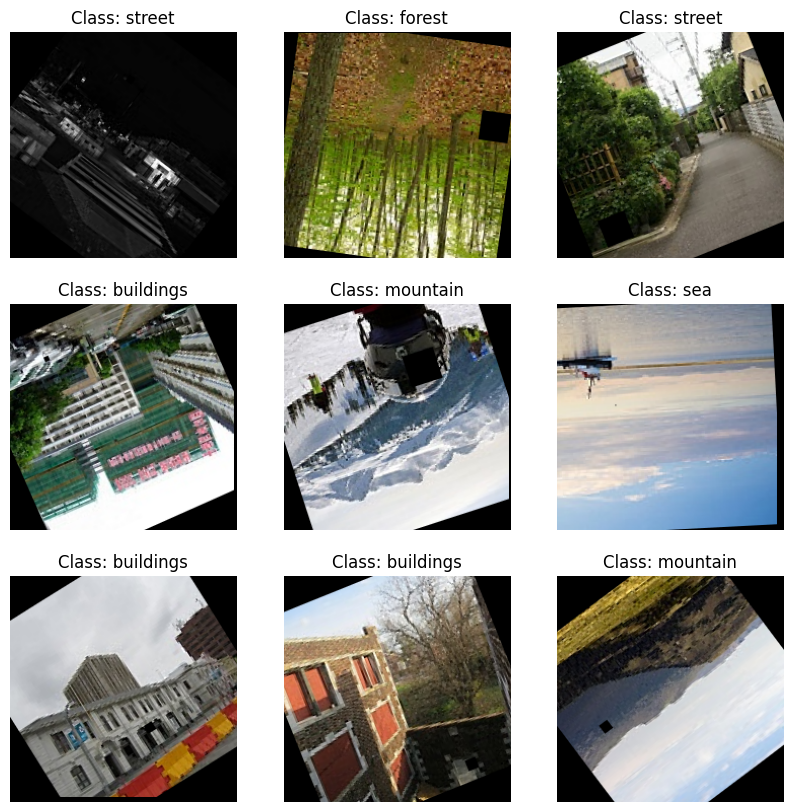

In [147]:
image,labels = next(train_data_gen)

plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(image[i].astype("uint8"))
    plt.axis('off')
    plt.title(f"Class: {reversed_class_indices[labels[i].argmax()]}")
plt.show()


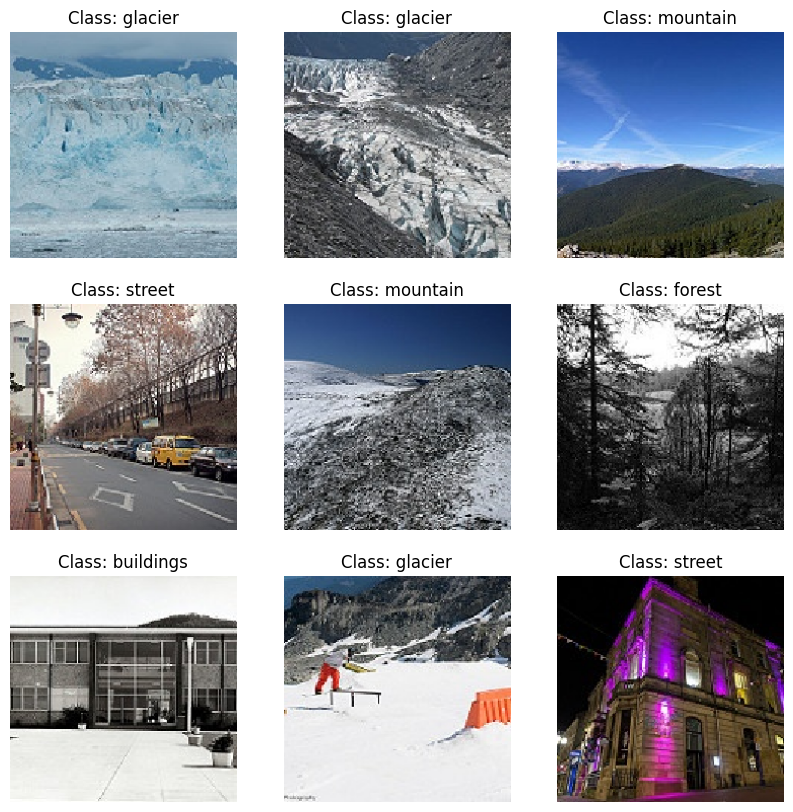

In [148]:
image,labels = next(val_data_gen)

plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(image[i].astype("uint8"))
    plt.axis('off')
    plt.title(f"Class: {reversed_class_indices[labels[i].argmax()]}")
plt.show()


# Building the model

In [149]:
# Define the model

model = tf.keras.Sequential()

# Input layer
model.add(tf.keras.Input(shape=(224, 224, 3)))  # Input layer

# Layer 1
model.add(tf.keras.layers.Dense(6, activation='relu'))  # Dense layer with ReLU activation

# Layer 2
model.add(tf.keras.layers.Conv2D(128, kernel_size=[2,2], padding='valid', activation='relu'))

# Layer 3 pooling
model.add(tf.keras.layers.MaxPooling2D(pool_size=[2,2], strides=2, padding='valid'))

# Layer 4
model.add(tf.keras.layers.Conv2D(64, kernel_size=[2,2], padding='valid', activation='relu'))

# Layer 5 pooling
model.add(tf.keras.layers.MaxPooling2D(pool_size=[2,2], strides=2, padding='valid'))

# Layer 6
model.add(tf.keras.layers.Conv2D(32, kernel_size=[2,2], padding='valid', activation='relu'))

# Layer 7 pooling
model.add(tf.keras.layers.MaxPooling2D(pool_size=[2,2], strides=2, padding='valid'))

# Layer 8
model.add(tf.keras.layers.Conv2D(32, kernel_size=[2,2], padding='valid', activation='relu'))

# Layer 9 pooling
model.add(tf.keras.layers.MaxPooling2D(pool_size=[2,2], strides=2, padding='valid'))

# Flatten before
model.add(tf.keras.layers.Flatten())

# Output layer
model.add(tf.keras.layers.Dense(6, activation='sigmoid'))

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 224, 224, 6)         │              24 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 223, 223, 128)       │           3,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 111, 111, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 110, 110, 64)        │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 55, 55, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 54, 54, 32)          │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 27, 27, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 26, 26, 32)          │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 5408)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 6)                   │          32,454 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 80,862 (315.87 KB)

 Trainable params: 80,862 (315.87 KB)

 Non-trainable params: 0 (0.00 B)

In [150]:
history = model.fit(train_data_gen,validation_data = val_data_gen, epochs = 50, verbose = 2)

Epoch 1/50
351/351 - 200s - 571ms/step - accuracy: 0.4592 - loss: 1.3854 - val_accuracy: 0.5909 - val_loss: 1.0678
Epoch 2/50
351/351 - 199s - 567ms/step - accuracy: 0.5601 - loss: 1.1119 - val_accuracy: 0.5931 - val_loss: 1.0610
Epoch 3/50
351/351 - 199s - 567ms/step - accuracy: 0.6028 - loss: 1.0168 - val_accuracy: 0.6658 - val_loss: 0.9270
Epoch 4/50
351/351 - 199s - 567ms/step - accuracy: 0.6439 - loss: 0.9369 - val_accuracy: 0.6922 - val_loss: 0.8671
Epoch 5/50
351/351 - 199s - 567ms/step - accuracy: 0.6576 - loss: 0.8922 - val_accuracy: 0.6897 - val_loss: 0.8750
Epoch 6/50
351/351 - 199s - 567ms/step - accuracy: 0.6677 - loss: 0.8708 - val_accuracy: 0.6969 - val_loss: 0.8460
Epoch 7/50
351/351 - 199s - 566ms/step - accuracy: 0.6760 - loss: 0.8558 - val_accuracy: 0.6958 - val_loss: 0.7936
Epoch 8/50
351/351 - 199s - 567ms/step - accuracy: 0.6865 - loss: 0.8277 - val_accuracy: 0.7140 - val_loss: 0.8036
Epoch 9/50
351/351 - 199s - 566ms/step - accuracy: 0.6985 - loss: 0.8100 - val_a

In [151]:
test_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(

    
)


# Load the test data
test_data_gen = test_image_generator.flow_from_directory(
    directory=test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,  # Do not shuffle for evaluation
    seed=42
)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_data_gen, verbose=2)

# Print the test results
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_acc}")


Found 3000 images belonging to 6 classes.
94/94 - 11s - 121ms/step - accuracy: 0.7757 - loss: 0.6434
Test loss: 0.6433699131011963
Test accuracy: 0.7756666541099548
